# Goals

# Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
import formulaic
import requests
import zipfile
import io
import math 
import csv

In [2]:
from IPython.display import display, HTML

# Parameters & Directories

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams["font.style"] = "normal"
plt.rcParams["axes.labelcolor"] = "gray"
plt.rcParams["text.color"] = "grey"
pd.set_option('mode.chained_assignment', None)

In [4]:
DIR = os.path.dirname(os.getcwd()) + "/"
DATA = DIR + "data/"
REFS = DIR + "references/"

In [5]:
enroll = pd.read_csv(DATA+"raw/"+"enroll_rates.tab", sep="\t")

In [6]:
enroll['WDICountryVWCode'].value_counts().sort_index()

WDICountryVWCode
ARG    149
AUT    181
BEL    174
BOL    119
BRA    154
CHE    141
CHL    158
COL    160
CRI    136
CUB    112
DEU    182
DNK    141
DOM     81
ECU    136
ESP    169
FIN    136
FRA    182
GBR    161
GRC    150
GTM    131
GUY    142
HND    109
HTI     73
IRL    159
ITA    141
JAM    136
MEX    131
NIC    135
NLD    160
NOR    174
PAN    103
PER    119
PRI    111
PRT    125
PRY    117
SLV    133
SWE    146
TTO    144
URY    134
VEN    125
Name: count, dtype: int64

In [7]:
keep_states = ["France", "Germany", "Austria", "Belgium", "Spain", "United Kingdom", "Portugal", "Italy",
               "Netherlands", "Greece", "Sweden", "Switzerland", "Denmark", "Finland", "Norway"]
iso_dct = {}
enroll = pd.read_csv(DATA+"raw/"+"enroll_rates.tab", sep="\t")
with open(DATA+"raw/"+"country_codes.txt", "r") as f: 
    lines = f.readlines()
    for line in lines:
        iso_dct[line.split("  ")[0]] = line.split("  ")[1].strip()

enroll['state'] = enroll['WDICountryVWCode'].apply(lambda x: iso_dct[x])
enroll = enroll[enroll['state'].isin(keep_states)]
enroll['sy_paglayan'] = enroll['primratio']
enroll = enroll[['state', 'year', 'sy_paglayan']]
enroll.to_csv(DATA+"interim/"+"paglayan.csv", index=False)
enroll.head()

,state,year,sy_paglayan
149,Austria,1830,17.40001
150,Austria,1831,17.40530
151,Austria,1832,NaN
152,Austria,1833,NaN
153,Austria,1834,18.32984


In [8]:
enroll['state'].nunique()

15

In [9]:
enroll['sy_paglayan'].describe()

count    2259.000000
mean       61.825913
std        18.936157
min         4.532761
25%        53.295310
50%        63.666840
75%        72.186835
max       124.000000
Name: sy_paglayan, dtype: float64

# Prepare Datasets

## Varieties of Democracy
A dataframe including annual time series describing the world population of states since 1789.

Source:
- [VDEM Project Description](https://www.v-dem.net/project.html)
- [VDEM Dataset Descriptions](https://www.v-dem.net/vdemds.html)
- [V12 Data .zip Download Link](https://v-dem.net/media/datasets/Country_Year_V-Dem_Fullothers_CSV_v12.zip) used in `request` below

Download Data Archive from VDEM Server

In [10]:
# uncomment to request data
# url = "https://v-dem.net/media/datasets/Country_Year_V-Dem_Fullothers_CSV_v12.zip"
# response = requests.get(url, stream=True)
# archive = zipfile.ZipFile(io.BytesIO(response.content))
# files = [file for file in archive.namelist() if "__" not in file]
# pdfs = [file for file in files if 'pdf' in file]
# csv = [file for file in files if 'csv' in file][0]

Extract Data & References into Directory

In [11]:
# CSV = archive.extract(csv, DATA+"raw/") # prints path of csv after extracted
# for pdf in pdfs: 
#     archive.extract(pdf, REFS)

In [10]:
DIR

'/Users/otto/Library/CloudStorage/GoogleDrive-danielscottsmith@gmail.com/My Drive/00_Researching/00_scientization/19cStates/'

In [88]:
CSV = DIR + "data/raw/Country_Year_V-Dem_Full+others_CSV_v12/V-Dem-CY-Full+Others-v12.csv"

# CSV = "/Users/otto/Downloads/V-Dem-CY-FullOthers_csv_v13/V-Dem-CY-Full+Others-v13.csv"

Read in data

In [89]:
vdem_sy = pd.read_csv(CSV, low_memory=False)
vdem_sy.shape

(27380, 4170)


Limit data to the 19th Century West

Regional Codes:
```
1: Western Europe
2: Northern Europe
3: Southern Europe
4: Eastern Europe
5: Northern Africa
6: Western Africa
7: Middle Africa
8: Eastern Africa
9: Southern Africa
10: Western Asia
11: Central Asia
12: Eastern Asia
13: South-Eastern Asia
14: Southern Asia
15: Oceania (including Australia and the Pacific)
16: North America
17: Central America
18: South America
19: Caribbean (including Belize, Cuba, Haiti, Dominican Republic and Guyana)
```

In [90]:
west = [1,2,3,4,15,16]
vdem_sy = vdem_sy.loc[(vdem_sy['year'] < 1915) & (vdem_sy['year'] > 1799)]
vdem_sy = vdem_sy[vdem_sy['e_regiongeo'].isin(west)]
vdem_sy.shape

(4054, 4170)

Rename variables (`sy` = state-year) and keep only a selection.

In [93]:
select_vars = ['country_name', 'year', 'v2elsuffrage', 'v2canuni', "e_mipopula",
               'v3stcensus', 'v3ststatag', 'v3ststybcov', 'v3ststybpub',
               'e_gdppc', 'e_miurbani', 'e_pelifeex', 'e_miinterc',
               'e_miinteco', 'v3stflag', 'v3stnatant', 'v3stcitlaw', 'v3pechilabl',
               'v2peprisch', 'v3stnatbank', 'v2svdomaut', 'v2svinlaut',
               'v2clacfree_ord', 'v2svindep', 'v2svstterr', 
               'v2pepwrsoc_ord','v2pepwrgen', 'v2pepwrses', 'v2strenadm',
               "v2x_clpol", "v2x_clpriv",
               "v2cltrnslw", "v2clrspct", "v2xnp_client"
              ]

var_names = ['state', 'year', 'sy_suffrage', 'sy_unis', "sy_pop",
             'sy_census', 'sy_stats_agency', 'sy_yrbk_cov', 'sy_yrbk_pub',
             'sy_gdp', 'sy_urban', 'sy_lifeex', 'sy_riots', 
             'sy_war', 'sy_flag','sy_anthem', 'sy_citizenship', 'sy_chldlbr',
             'sy_sch_enrll', 'sy_nat_bank','sy_dom_autonomy', 'sy_int_autonomy', 
             'sy_acad_free','sy_indep', 'sy_territory', 
             'sy_estates', 'sy_gender', 'sy_genteel','sy_bureau',
             "sy_pollib", "sy_civlib",
             "sy_trnsprnt", "sy_brcrcy", "sy_client"
            ]

var_map = dict(zip(select_vars, var_names))
vdem_sy.rename(columns=var_map, inplace=True)
vdem_sy = vdem_sy[var_names]
vdem_sy.shape

(4054, 34)

In [17]:
for c in vdem_sy['state'].unique():
    if "States" in c:
        print(c)

United States of America
Papal States


Generate a binary indicator series for when a given state had its first census.

In [15]:
# Gen annual series describing cumulative sum of censuses, by state
vdem_sy["sy_census_cum"] = vdem_sy.groupby(["state"])["sy_census"].cumsum()

# Create dummy variable of first ever
vdem_sy["sy_census_ever"] = 0

# ID first ever census as when state conducts census and cum censuses is 1
vdem_sy.loc[(vdem_sy['sy_census_cum'] != 0), 'sy_census_ever'] = 1

# Drop the other census vars
vdem_sy.drop(["sy_census"], axis=1, inplace=True)

In [16]:
vdem_sy[['year', 'state', 'sy_census_cum', 'sy_census_ever']]

,year,state,sy_census_cum,sy_census_ever
366,1800,Sweden,1.0,1
367,1801,Sweden,1.0,1
368,1802,Sweden,1.0,1
369,1803,Sweden,1.0,1
370,1804,Sweden,1.0,1
...,...,...,...,...
27375,1857,Piedmont-Sardinia,NaN,1
27376,1858,Piedmont-Sardinia,NaN,1
27377,1859,Piedmont-Sardinia,NaN,1
27378,1860,Piedmont-Sardinia,NaN,1


In [17]:
vdem_sy = vdem_sy.merge(vdem_sy.groupby("year", as_index=False)['state'].size().rename(columns={"size": "wy_nstates"}), on="year")

Extrapolate pre-1819 school enrollment rates using the slope of enrollment on year, 1819–1824

In [18]:
# excerpt earliest 5 years of enrollment
vdem_xcrpt = vdem_sy[(vdem_sy['year']>1819) & (vdem_sy['year']<1839)][['state', 'sy_sch_enrll', 'year']]
enrlls = []
# loop through each state
for state, df in vdem_xcrpt.groupby("state"):
    # transform enrollment & year series into matrices
    y, X = formulaic.Formula('sy_sch_enrll ~ year').get_model_matrix(df)
    # fit OLS model of enrollment on year
    try:
        betas = sm.OLS(y, X, missing="drop").fit().params
    except:
        pass
    # predict missing years based on slope of year on enrollment, 1819-1824
    for yr in range(1800,1820,1):
        enrll = betas.year * yr + betas.Intercept
        if enrll > 0:
            enrlls.append((yr, state, enrll))
        else:
            enrlls.append((yr, state, 0))

In [19]:
# create new data frame with original enrollment + new extrapolated enrollment
xtr_sy_enrll = vdem_sy.merge(pd.DataFrame.from_records(enrlls, columns=["year", "state", "early_enrll"]), how="left", on=['year', 'state'])[["year","state","sy_sch_enrll", "early_enrll"]]


vdem_sy['sy_xtr_enrll'] = xtr_sy_enrll['sy_sch_enrll'].replace('', pd.NA).fillna(xtr_sy_enrll['early_enrll'])
vdem_sy[["state", "year", "sy_sch_enrll","sy_xtr_enrll"]].sort_values(by=["state", "year"])

,state,year,sy_sch_enrll,sy_xtr_enrll
3958,Albania,1912,13.342,13.342000
3991,Albania,1913,13.932,13.932000
4024,Albania,1914,14.522,14.522000
5,Australia,1800,NaN,22.742874
38,Australia,1801,NaN,23.294116
...,...,...,...,...
2722,Würtemberg,1867,NaN,NaN
2757,Würtemberg,1868,NaN,NaN
2787,Würtemberg,1869,NaN,NaN
2817,Würtemberg,1870,NaN,NaN


Visualize extrapolated enrollment rates

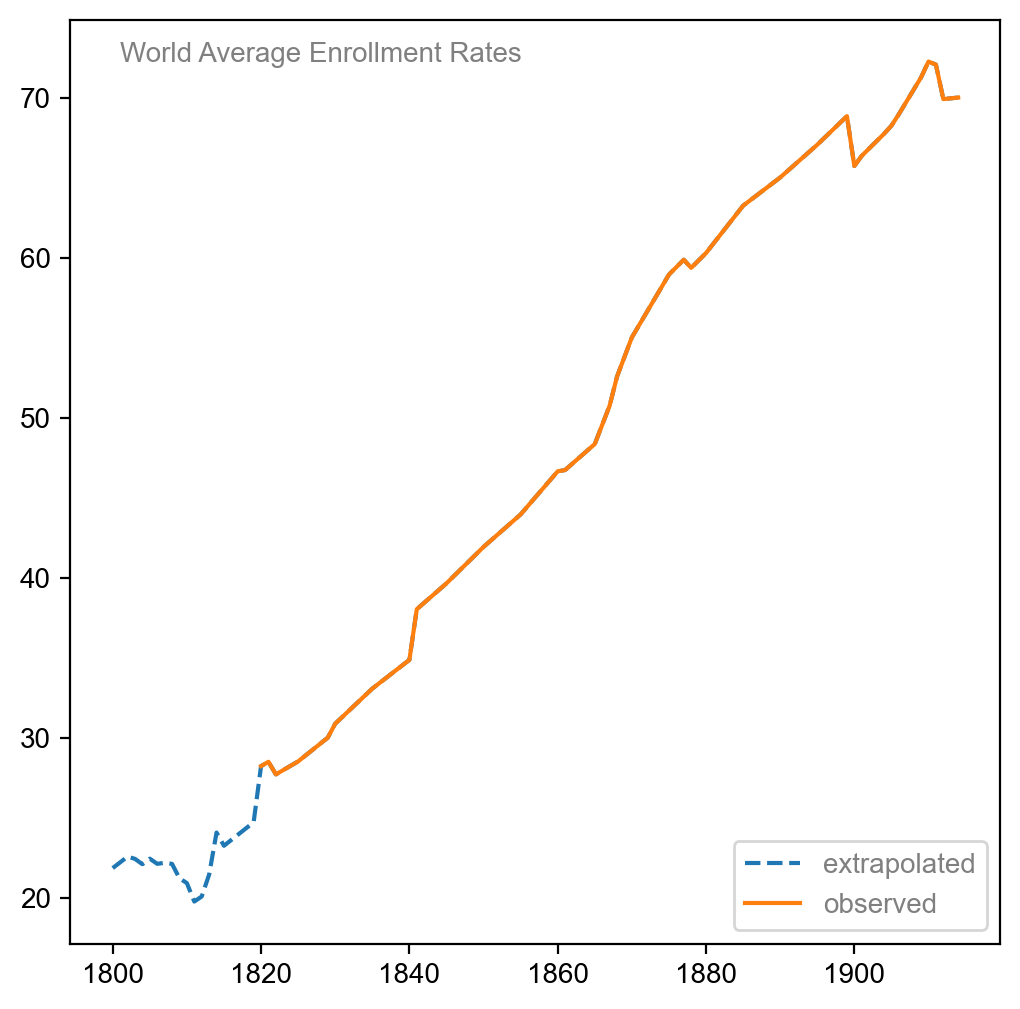

In [20]:
plt.plot(list(set(vdem_sy["year"].values)),
         vdem_sy.groupby("year")["sy_xtr_enrll"].mean(),
         linestyle="--",
         label = "extrapolated")
plt.plot(list(set(vdem_sy["year"].values)),
         vdem_sy.groupby("year")["sy_sch_enrll"].mean(),
         label = "observed")
plt.legend(loc="lower right")
plt.text(1801, vdem_sy.groupby("year")["sy_sch_enrll"].mean().max(), "World Average Enrollment Rates")
plt.show()

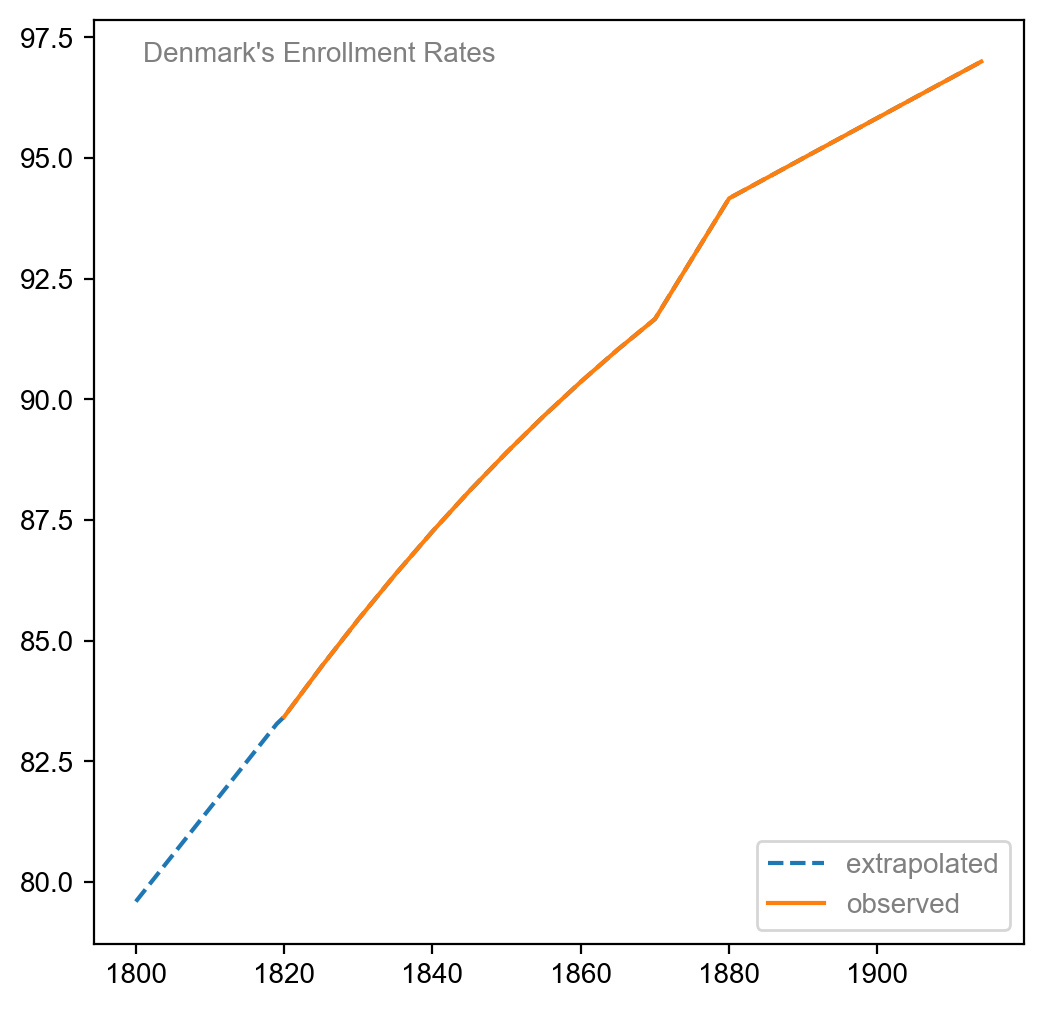

In [21]:
pick1 = random.choice(vdem_sy['state'].values)
pick1_df = vdem_sy[vdem_sy['state']==pick1][["year", "sy_xtr_enrll", "sy_sch_enrll"]]
plt.plot(pick1_df['year'],
         pick1_df['sy_xtr_enrll'],
         linestyle="--",
         label = "extrapolated")
plt.plot(pick1_df['year'],
         pick1_df["sy_sch_enrll"],
         label = "observed")
plt.legend(loc="lower right")
plt.text(pick1_df['year'].min()+1,
         vdem_sy[vdem_sy['state']==pick1]["sy_xtr_enrll"].max(),
         "{}'s Enrollment Rates".format(pick1))
plt.show()

Recode

In [22]:
vdem_sy[vdem_sy['sy_urban'].isna()]['year'].max()

1914

Autonomy
```
0: Non-autonomous. Foreign policy is controlled by an external power, either de facto or de jure. The most common examples of this are colonial rule and military occupation (e.g. quadripartite occupation of Germany in 1945). Situations in which domestic actors provide de jure cover for de facto control by a foreign power should not be construed as semi-autonomy (e.g. Vichy France). Governments in exile that control underground forces waging unconventional warfare are not considered as mitigating an occupation regime (e.g. countries under German occupation during WWII).
1: Semi-autonomous. An external political actor directly constrains the ability of domestic actors to pursue an independent foreign policy course in some important areas. This may be the product of explicit treaty provisions or well-understood rules of the game from which the subject state cannot withdraw. Examples would include Soviet strictures over rule in so-called "satellite" states in Eastern Europe, and explicitly negotiated postwar settlements (e.g. Austria following WWII).
2: Autonomous. Domestic political actors exercise foreign policy free of the direct control of external political actors. Direct control is meant to exclude the exercise of constraint or the impact of interdependence in the international system. Treaties in which states concede some part of that control to a supra- or international organization voluntarily, and from which there is a possibility of exit should not be interpreted as a violation of autonomy.
```

Bureaucratic remuneration
```
0: None or almost none are salaried state employees. 
1: A small share is salaried state employees.
2. About half are salaried state employees.
3: A substantial number are salaried state employees. 
4: All or almost all are salaried state employees.
```

Power distributed by social groups
```
0: Political power is monopolized by one social group comprising a minority of the population. This monopoly is institutionalized, i.e., not subject to frequent change.
1: Political power is monopolized by several social groups comprising a minority of the population. This monopoly is institutionalized, i.e., not subject to frequent change.
2: Political power is monopolized by several social groups comprising a majority of the population. This monopoly is institutionalized, i.e., not subject to frequent change.
3: Either all social groups possess some political power, with some groups having more power than others; or different social groups alternate in power, with one group controlling much of the political power for a period of time, followed by another — but all significant groups have a turn at the seat of power.
4: All social groups have roughly equal political power or there are no strong ethnic, caste, linguistic, racial, religious, or regional differences to speak of. Social group characteristics are not relevant to politics.
```

Freedom of academic and cultural expression
```
0: Not respected by public authorities. Censorship and intimidation are frequent. Academic activities and cultural expressions are severely restricted or controlled by the government.
1: Weakly respected by public authorities. Academic freedom and freedom of cultural expression are practiced occasionally, but direct criticism of the government is mostly met with repression.
2: Somewhat respected by public authorities. Academic freedom and freedom of cultural expression are practiced routinely, but strong criticism of the government is sometimes met with repression.
3: Mostly respected by public authorities. There are few limitations on academic freedom and freedom of cultural expression, and resulting sanctions tend to be infrequent and soft.
4: Fully respected by public authorities. There are no restrictions on academic freedom or cultural expression.
```

In [23]:
vdem_sy["sy_dom_autonomy_b"] = np.where(vdem_sy['sy_dom_autonomy'] < 1, 0, 1)
vdem_sy["sy_int_autonomy_b"] = np.where(vdem_sy['sy_int_autonomy'] < 1, 0, 1)

In [24]:
vdem_sy["sy_bureau_b"] = np.where(vdem_sy['sy_bureau'] < 1, 0, 1)
vdem_sy["sy_estates_b"] = np.where(vdem_sy['sy_estates'] < 2, 0, 1)

In [25]:
vdem_sy["sy_acad_free_b"] = np.where(vdem_sy['sy_acad_free'] < 1, 0, 1)

In [26]:
vdem_sy['sy_territory'].fillna(0, inplace=True)

### Education Ministries

In [27]:
moe_years = pd.read_csv(DATA+"raw/"+"moe_years.csv")
moe_dct = dict(zip(moe_years['state'], moe_years['moe_year']))

In [28]:
def code_moe(year, state, dct):
    if state in dct:
        all_years = list(range(dct[state], 1915))
        if year in all_years: 
            return 1
        else:
            return 0

In [29]:
vdem_sy['sy_ministry'] = vdem_sy[['year', 'state']].apply(lambda x: code_moe(x.iloc[0], x.iloc[1], moe_dct), axis=1)

In [30]:
state = "Belgium"

In [31]:
moe_dct[state]

1878

In [32]:
vdem_sy[vdem_sy['state']==state][['year', 'state', 'sy_ministry']].sort_values(by=['state', 'year'])

,year,state,sy_ministry
1124,1830,Belgium,0.0
1166,1831,Belgium,0.0
1208,1832,Belgium,0.0
1250,1833,Belgium,0.0
1292,1834,Belgium,0.0
...,...,...,...
3906,1910,Belgium,1.0
3938,1911,Belgium,1.0
3971,1912,Belgium,1.0
4004,1913,Belgium,1.0


Create world-level means of state-level series for each state, minus itself

In [33]:
vdem_sy.columns

Index(['state', 'year', 'sy_suffrage', 'sy_unis', 'sy_pop', 'sy_stats_agency',
       'sy_yrbk_cov', 'sy_yrbk_pub', 'sy_gdp', 'sy_urban', 'sy_lifeex',
       'sy_riots', 'sy_war', 'sy_flag', 'sy_anthem', 'sy_citizenship',
       'sy_chldlbr', 'sy_sch_enrll', 'sy_nat_bank', 'sy_dom_autonomy',
       'sy_int_autonomy', 'sy_acad_free', 'sy_indep', 'sy_territory',
       'sy_estates', 'sy_gender', 'sy_genteel', 'sy_bureau', 'sy_pollib',
       'sy_civlib', 'sy_trnsprnt', 'sy_brcrcy', 'sy_client', 'sy_census_cum',
       'sy_census_ever', 'wy_nstates', 'sy_xtr_enrll', 'sy_dom_autonomy_b',
       'sy_int_autonomy_b', 'sy_bureau_b', 'sy_estates_b', 'sy_acad_free_b',
       'sy_ministry'],
      dtype='object')

In [99]:
state_dfs = []
for state in set(vdem_sy['state']):

    # state's institutional env df
    wrld_df = vdem_sy[vdem_sy['state']!=state]

    # state's own df
    state_sy = vdem_sy[vdem_sy['state'] == state]

    # remove world-year ("wy_") series that don't vary by state
    excluded_vars = wrld_df.columns.str.startswith('wy')
    wrld_df = wrld_df.loc[:,~excluded_vars]
    var_map = {}

    # rename columns to reflect world year level
    for col in wrld_df.columns:
        if "sy_" in col:
            wy = col.replace("sy_", "wy_")
            var_map[col] = wy
        else:
            var_map[col] = col
    wrld_df.rename(columns=var_map, inplace=True)

    # compute world-year series by averaging all countries in a year, minus state
    wrld_df = wrld_df.groupby("year", as_index=False).mean(numeric_only=True)
    
    # merge omitted state's world env df to its sy df
    # this contains all original state-level chars
    # and now it's institutional level chars
    state_sy = state_sy.merge(wrld_df, how='left', on=['year'])

    # add state to collection
    state_dfs.append(state_sy)

# make colleciton into df
# replacing old one
states_df = pd.concat(state_dfs, ignore_index=True)

In [36]:
print(sorted(set(states_df['state'])), '\n\n',
      len(set(states_df['state'])), 'states in total')

['Albania', 'Australia', 'Austria', 'Baden', 'Bavaria', 'Belgium', 'Brunswick', 'Bulgaria', 'Canada', 'Denmark', 'Fiji', 'Finland', 'France', 'Germany', 'Greece', 'Hamburg', 'Hanover', 'Hesse-Darmstadt', 'Hesse-Kassel', 'Hungary', 'Iceland', 'Italy', 'Luxembourg', 'Malta', 'Mecklenburg Schwerin', 'Modena', 'Montenegro', 'Nassau', 'Netherlands', 'New Zealand', 'Norway', 'Oldenburg', 'Papal States', 'Papua New Guinea', 'Parma', 'Piedmont-Sardinia', 'Poland', 'Portugal', 'Romania', 'Russia', 'Saxe-Weimar-Eisenach', 'Saxony', 'Serbia', 'Solomon Islands', 'Spain', 'Sweden', 'Switzerland', 'Tuscany', 'Two Sicilies', 'United Kingdom', 'United States of America', 'Vanuatu', 'Würtemberg'] 

 53 states in total


In [97]:
states_df['year'].min()

1800

In [98]:
states_df['year'].max()

1914

## Statistics societies
A dataframe that includes two annual times series describing the number of statistics societies foundings and the cumulative number of statistics societies worldwide.

Sources:
- Willcox, W. F. (1934). Note on the Chronology of Statistical Societies. Journal of the American Statistical Association, 29(188). [DOI](https://doi.org/10.1080/01621459.1934.10503258)
- Fitzpatrick, P. J. (1957). Statistical Societies in the United States the Nineteenth Century. The American Statistician, 11(5). [DOI](https://doi.org/10.1080/00031305.1957.10481745)

Read in data

In [39]:
societies_wy = pd.read_csv(DATA+"raw/societies.csv")
societies_wy.head()

,year,n_societies,all_societies
0,1800,1,1
1,1801,0,1
2,1802,0,1
3,1803,1,2
4,1804,0,2


Clean variables

In [40]:
rename = {"all_societies": "wy_societies"}
societies_wy = societies_wy.rename(columns=rename)
societies_wy.drop(["n_societies"], axis=1, inplace=True)
societies_wy.head()

,year,wy_societies
0,1800,1
1,1801,1
2,1802,1
3,1803,2
4,1804,2


In [41]:
societies_wy['year'].min()

1800

In [42]:
societies_wy['year'].max()

1913


## World Congresses
An annual time series describing the number of international conferences hosted in a state, with specific reference to social science and social reform. See notebook `cr_congresses_sy` for processing.

Data Sources:
- UIA (1960) Les Congrès Internationaux de 1681 à 1899 Liste Complète / International Congresses 1681 to 1899 Full List. Bruxelles: Union of International Associations.
- UIA (1964) Les Congrès Internationaux de 1900 à 1919 Liste Complète / International Congresses 1900 to 1913 Full List. Bruxelles: Union of International Associations. [Stanford SearchWorks Catalogue](https://searchworks.stanford.edu/view/1830221)

Secondary Source:
- Leonards, Chris, and Nico Randeraad (2010) “Transnational Experts in Social Reform, 1840–1880.” International Review of Social History 55 (2): 215–39. [DOI](https://doi.org/10.1017/S0020859010000179)


Read in congress data

In [43]:
congresses_sy = pd.read_csv(DATA + "interim/" + "19c_congresses_sy.csv")

Clean data

In [44]:
congresses_sy = congresses_sy.fillna(0)
congresses_sy = congresses_sy.rename(columns={"n_confs_ttl": "sy_confs_ttl",
                                              "n_confs_sci_ref": "sy_confs_sci_ref",
                                              "n_confs_sci": "sy_confs_sci"})
congresses_sy.sample(5)

,year,state,sy_confs_ttl,sy_confs_sci_ref,sy_confs_sci
290,1807,Sweden,0,0,0
3147,1885,Argentina,0,0,0
4081,1910,El Salvador,1,0,0
2889,1878,Australia,0,0,0
1825,1849,France,1,1,0


Inspect

In [45]:
congresses_sy['state'].value_counts().sample(5)

state
Peru                        114
Benin                       114
New Zealand                 114
Austria                     114
United States of America    114
Name: count, dtype: int64

Create world-level annual series by suming up all state-year obs to create world-wide annual series

In [46]:
var_map = {"sy_confs_ttl": "wy_confs_ttl",
       "sy_confs_sci_ref": "wy_confs_sci_ref",
       "sy_confs_sci": "wy_confs_sci"}
congresses_wy = congresses_sy.groupby('year',
                                      as_index=False).sum(numeric_only=True).rename(columns=var_map)
congresses_wy.sample(5)

,year,wy_confs_ttl,wy_confs_sci_ref,wy_confs_sci
93,1893,95,22,9
71,1871,15,3,1
85,1885,36,12,7
64,1864,9,3,1
52,1852,1,0,0


In [47]:
congresses_wy['year'].min()

1800

In [48]:
congresses_wy.isna().sum()

year                0
wy_confs_ttl        0
wy_confs_sci_ref    0
wy_confs_sci        0
dtype: int64

## Social Science Periodicals

In [49]:
journals_wy = pd.read_csv(DATA + "interim/" + "19c_journals_wy.csv")

In [50]:
journals_wy.sample(5)

,wy_stats_journals,year,wy_soc_journals
101,1561,1901,618
0,9,1800,3
32,54,1832,13
15,13,1815,4
88,1114,1888,402


In [51]:
journals_wy['year'].min()

1800

## Population
- [Bairoch & Goertz](https://journals.sagepub.com/doi/epdf/10.1080/00420988620080351)
- [Bukowsky et al](https://www.tandfonline.com/doi/full/10.1080/01615440.2019.1580171)

In [55]:
DIR

'/Users/otto/Library/CloudStorage/GoogleDrive-danielscottsmith@gmail.com/My Drive/00_Researching/00_scientization/19cStates/'

In [57]:
pop_df = pd.read_csv(DATA+"raw/tabula-urban.csv", usecols=[0,2,3,4,5,6,7])
pop_df = pop_df.rename(columns={"Unnamed: 0": "state"})

In [58]:
pop_df.head()

,state,1800,1830,1850,1880,1900,1910
0,Austria-Hungary,6.5,7.1,9.7,16.0,25.6,28.5
1,Belgium,20.5,(25.0),33.5,43.1,52.3,56.6
2,Bulgaria,5.5,(5.5),(6.0),(11.0),15.0,22.1
3,Denmark,15.6,14.1,14.6,23.0,33.5,35.9
4,Finland,3.5,3.5,3.7,6.1,10.4,12.6


In [59]:
with open(DATA+"raw/tabula-urban.csv", "r") as f:
    reader = csv.reader(f)
    dct = {}
    for i, row in enumerate(reader):
        new_vals = [val.replace("(", "") for val in row[2:]]
        if i == 0: 
            YEARS = [int(year) for year in row[2:]]
        else:
            dct[row[0]] = [float(val.replace(")", "")) for val in new_vals]
dct['Austria'] = dct['Austria-Hungary']
dct['Hungary'] = dct['Austria-Hungary']
dct['Hungary'] = dct['Austria-Hungary']
dct['Australia'] = dct['OTHER DEVELOPED COUNTRIES']
dct['New Zealand'] = dct['OTHER DEVELOPED COUNTRIES']
dct['United States of America'] = dct['United States']

In [60]:
YEARS

[1800, 1830, 1850, 1880, 1900, 1910]

In [61]:
dct

{'Austria-Hungary': [6.5, 7.1, 9.7, 16.0, 25.6, 28.5],
 'Belgium': [20.5, 25.0, 33.5, 43.1, 52.3, 56.6],
 'Bulgaria': [5.5, 5.5, 6.0, 11.0, 15.0, 22.1],
 'Denmark': [15.6, 14.1, 14.6, 23.0, 33.5, 35.9],
 'Finland': [3.5, 3.5, 3.7, 6.1, 10.4, 12.6],
 'France': [12.2, 15.7, 19.5, 27.6, 35.4, 38.5],
 'Germany': [8.9, 9.1, 15.0, 29.1, 42.0, 48.8],
 'Greece': [11.5, 12.0, 14.0, 16.0, 21.0, 22.0],
 'Italy': [18.0, 19.0, 23.0, 28.0, 35.5, 40.0],
 'Netherlands': [37.4, 35.8, 35.6, 44.5, 47.8, 50.5],
 'Norway': [7.0, 7.2, 9.0, 16.0, 24.3, 25.1],
 'Portugal': [15.5, 15.0, 15.0, 15.0, 15.7, 15.6],
 'Romania': [7.5, 7.5, 11.0, 14.0, 17.3, 16.0],
 'Russia': [5.9, 6.0, 7.2, 10.6, 13.2, 14.3],
 'Serbia': [10.0, 10.0, 10.0, 10.0, 9.8, 10.0],
 'Spain': [17.5, 17.5, 18.0, 26.0, 34.0, 38.0],
 'Sweden': [6.6, 6.6, 6.8, 12.5, 19.3, 22.6],
 'Switzerland': [7.0, 7.5, 11.9, 20.4, 30.6, 37.1],
 'United Kingdom': [19.2, 27.5, 39.6, 56.2, 67.4, 69.2],
 'OTHER DEVELOPED COUNTRIES': [5.5, 7.9, 13.9, 24.4, 35.6, 41

In [62]:
states_df['state'].sample()

1877    Australia
Name: state, dtype: object

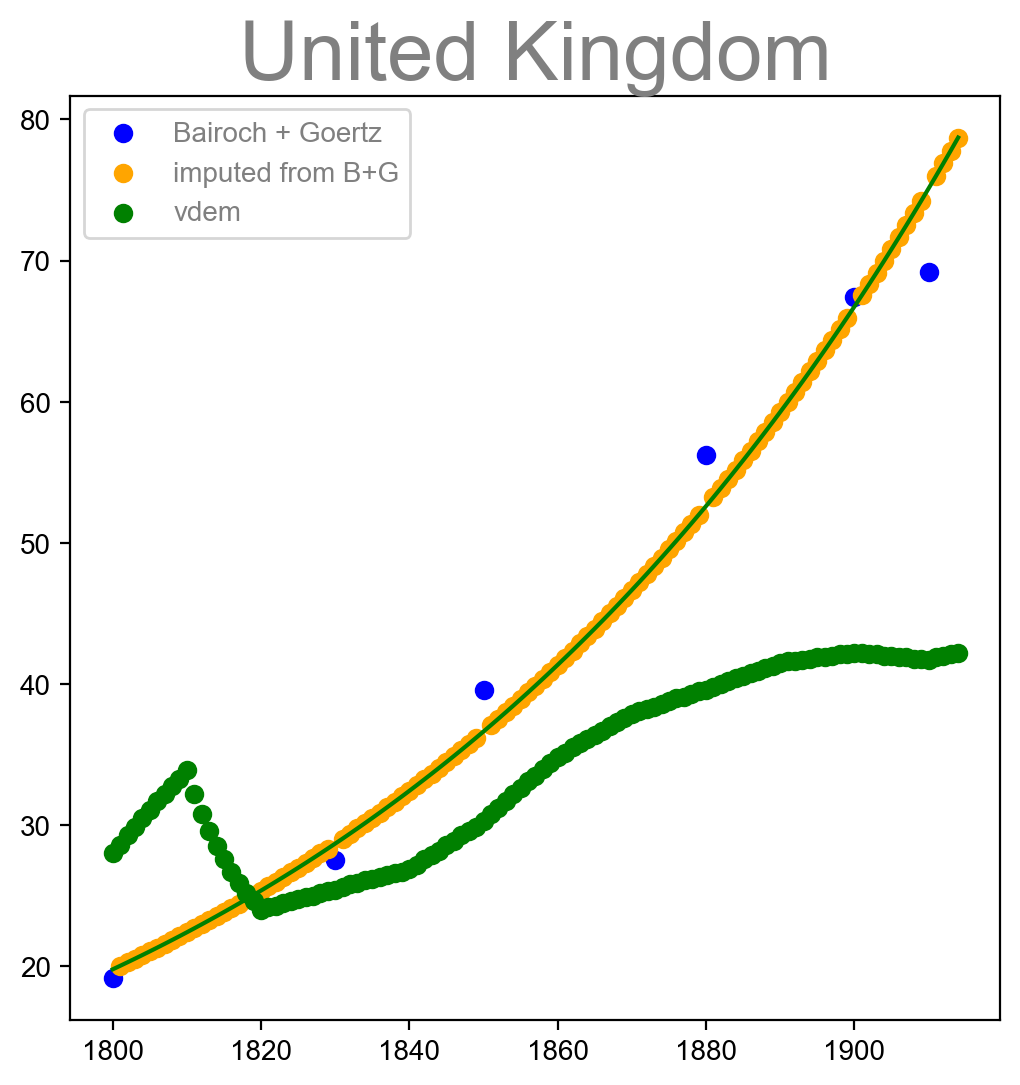

In [63]:
# state
state = random.choice(list(dct.keys()))
# state = "Hungary"

# Convert to log-log scale and fit the data to a line.
log_years = np.log(YEARS)
log_rates = np.log(dct[state])
coefficients = np.polyfit(log_years, log_rates, 1)

# Define the power law function.
a = math.exp(coefficients[1])  # intercept
b = coefficients[0]  # slope

def power_law(x):
    return a * (x ** b)

# Impute the data points for the missing years.
missing_years = np.array([year for year in range(1800, 1915) if year not in YEARS])
imputed_data = power_law(missing_years)

# Visualize the data
plt.scatter(YEARS, dct[state], color='blue', label="Bairoch + Goertz")  # Original data
plt.scatter(missing_years, imputed_data, color='orange', label="imputed from B+G")  # Imputed data
plt.scatter(vdem_sy[vdem_sy['state']==state][['year']], 
            vdem_sy[vdem_sy['state']==state][['sy_urban']]*100, color='green', label="vdem") # vdem
plt.plot(np.arange(1800, 1915), power_law(np.arange(1800, 1915)), color='green')  # Power law line
plt.title(f"{state}", size=30)
plt.legend()
plt.show()

In [64]:
# Define your known points.
YEARS = np.array([1800, 1830, 1850, 1880, 1900, 1910]) 

def power_law(x):
    return a * (x ** b)

def impute_data(state, years, rates):
    # Convert to log-log scale and fit the data to a line.
    log_years = np.log(years)
    log_rates = np.log(rates)
    coefficients = np.polyfit(log_years, log_rates, 1)

    # Define the power law function.
    a = math.exp(coefficients[1])  # intercept
    b = coefficients[0]  # slope


    # Impute the data points for the missing years.
    missing_years = np.array([year for year in range(1800, 1915) if year not in years])
    imputed_rates = power_law(missing_years)
    # imputed_rates = power_law(YEARS)
    
    state_names = [state]*len(missing_years)
    data = list(zip(state_names, missing_years, imputed_rates))

    for year, rate in zip(years, rates):
        data.append((state, year, rate))
    
    data = sorted(data)

    
    return pd.DataFrame.from_records(data, columns=['state', 'year', 'sy_xtr_urban'])
    

In [65]:
dfs = []
for state, rates in dct.items():
    dfs.append(impute_data(state, YEARS, rates))

In [66]:
dfs.append(impute_data("Poland", 
                       [1790, 1810, 1830, 1850, 1870, 1890, 1910], 
                       [5.1, 5.7, 7.6, 10.1, 14.1, 20.5, 30.0]))

In [67]:
xtr_urban_sy = pd.concat(dfs)

In [68]:
xtr_urban_sy

,state,year,sy_xtr_urban
0,Austria-Hungary,1800,6.500000
1,Austria-Hungary,1801,20.031339
2,Austria-Hungary,1802,20.282962
3,Austria-Hungary,1803,20.537604
4,Austria-Hungary,1804,20.795299
...,...,...,...
111,Poland,1910,30.000000
112,Poland,1911,75.984071
113,Poland,1912,76.883294
114,Poland,1913,77.792680


In [69]:
xtr_urban_sy.isna().sum()

state           0
year            0
sy_xtr_urban    0
dtype: int64

In [70]:
xtr_urban_sy['state'].nunique()

28

In [71]:
xtr_urban_sy['state'].unique()

array(['Austria-Hungary', 'Belgium', 'Bulgaria', 'Denmark', 'Finland',
       'France', 'Germany', 'Greece', 'Italy', 'Netherlands', 'Norway',
       'Portugal', 'Romania', 'Russia', 'Serbia', 'Spain', 'Sweden',
       'Switzerland', 'United Kingdom', 'OTHER DEVELOPED COUNTRIES',
       'Canada', 'United States', 'Austria', 'Hungary', 'Australia',
       'New Zealand', 'United States of America', 'Poland'], dtype=object)

# Merge data

In [72]:
states_df = states_df.merge(congresses_sy, on=['year', 'state'], how='left', validate="one_to_one")

In [73]:
states_df = states_df.merge(congresses_wy, on=['year'], how='left', validate="many_to_one")

In [74]:
states_df = states_df.merge(societies_wy, on=['year'], how='left', validate="many_to_one")

In [75]:
states_df = states_df.merge(journals_wy, on=['year'], how='left', validate="many_to_one")

In [76]:
states_df = states_df.merge(xtr_urban_sy, on=['year', 'state'], how='left', validate="one_to_one")

In [77]:
states_df['sy_xtr_urban'].isna().sum()

1522

In [78]:
states_df[['state', 'year', 'sy_xtr_urban']]

,state,year,sy_xtr_urban
0,Netherlands,1800,37.400000
1,Netherlands,1801,20.031339
2,Netherlands,1802,20.282962
3,Netherlands,1803,20.537604
4,Netherlands,1804,20.795299
...,...,...,...
4049,Hamburg,1863,NaN
4050,Hamburg,1864,NaN
4051,Hamburg,1865,NaN
4052,Hamburg,1866,NaN


# Select states with non-missing data

We'll fill in nans for congress data; nan means no congress, i.e. 0

In [79]:
states_df[["sy_confs_sci", "sy_confs_ttl", "sy_confs_sci_ref"]] = states_df[["sy_confs_sci", "sy_confs_ttl", "sy_confs_sci_ref"]].fillna(0)

We'll keep those without empty columns

In [80]:
states_df['state'].value_counts()

state
Germany                     115
Hungary                     115
United States of America    115
Norway                      115
United Kingdom              115
Portugal                    115
Austria                     115
Russia                      115
Montenegro                  115
Switzerland                 115
Spain                       115
France                      115
Denmark                     115
Sweden                      115
Australia                   115
Romania                     115
Netherlands                 113
Serbia                      110
Finland                     106
Luxembourg                  100
Greece                       93
Belgium                      85
New Zealand                  74
Canada                       74
Baden                        72
Würtemberg                   72
Hesse-Darmstadt              72
Bavaria                      72
Hamburg                      68
Mecklenburg Schwerin         68
Saxony                       68
Pa

In [81]:
keep_states = []
for state, state_df in states_df.groupby('state'):
    n_miss = 0
    cols = []
    for col, val in state_df.isna().sum().items():
        if int(round(val / state_df.shape[0])) == int(1):
            n_miss += 1
            print(state, "completely missing", col)
            # if col == "sy_urban":
            #     print(state)
    if n_miss < 6: 
        keep_states.append(state)
        print("KEPT", state)
    print()
# print()
print("n kept states:", len(keep_states))

Albania completely missing sy_pop
Albania completely missing sy_stats_agency
Albania completely missing sy_yrbk_cov
Albania completely missing sy_yrbk_pub
Albania completely missing sy_urban
Albania completely missing sy_flag
Albania completely missing sy_anthem
Albania completely missing sy_citizenship
Albania completely missing sy_chldlbr
Albania completely missing sy_nat_bank
Albania completely missing sy_census_cum
Albania completely missing sy_ministry
Albania completely missing sy_xtr_urban

KEPT Australia

KEPT Austria

Baden completely missing sy_unis
Baden completely missing sy_pop
Baden completely missing sy_stats_agency
Baden completely missing sy_yrbk_cov
Baden completely missing sy_yrbk_pub
Baden completely missing sy_urban
Baden completely missing sy_lifeex
Baden completely missing sy_riots
Baden completely missing sy_war
Baden completely missing sy_sch_enrll
Baden completely missing sy_census_cum
Baden completely missing sy_xtr_enrll
Baden completely missing sy_ministry


In [82]:
state = "United States of America"
vs = []
for var, val in states_df[states_df['state']==state].isna().sum().items():
    if val > 0: 
        print(var, val)
        vs.append(var)

sy_sch_enrll 20
wy_sch_enrll 20
wy_confs_ttl 1
wy_confs_sci_ref 1
wy_confs_sci 1
wy_societies 1


In [83]:
states_df[states_df['state']=='Poland'].shape[0]

61

In [84]:
states_df = states_df[states_df['state'].isin(keep_states)]
states_df.shape

(2532, 93)

Create a decade dummy

In [82]:
states_df['decade'] = pd.cut(states_df['year'], bins=10, labels=[str(i)+'s' for i in range(1820,1915,10)])

In [85]:
states_df.to_csv(DATA + "interim/" + "int_19cStates.csv", index=False)